<a href="https://www.kaggle.com/code/nikhil1e9/s3-e20-eda?scriptVersionId=139781931" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview of the problem

The dataset contains open-source emissions data (from [Sentinel-5P](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p) satellite observations) The challenge is to predict carbon emissions across Rwanda from the given data

The data for this competition is split by time; the years 2019 - 2021 are included in the training data, and the task is to predict the CO2 emissions data for 2022 through November. Each year includes weekly data. There are seven main features which were extracted weekly from Sentinel-5P from January 2019 to November 2022. Each feature contain sub features such as column_number_density which is the vertical column density at ground level etc.

<!--
<img src="https://geographical.co.uk/wp-content/uploads/carbon-dioxide-emissions-title-1200x800.jpg" width="600" height="600">
-->
#### NO2 concentrations across the globe as observed from the satellite
![](https://developers.google.com/static/earth-engine/images/datasets/copernicus_s5p_no2_1280_856.jpg)

##### Source: https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p

### Some domain knowledge

Here is a brief summary of the pollutants given in the dataset

- **Sulfur dioxide (SO2)** enters the Earth's atmosphere through both natural and anthropogenic processes. Only about 30% of the emitted SO2 comes from natural sources; the majority is of anthropogenic origin. SO2 emissions adversely affect human health and air quality. SO2 has an effect on climate through radiative forcing, via the formation of sulfate aerosols.

- **Carbon monoxide (CO)** is an important atmospheric trace gas for understanding tropospheric chemistry. In certain urban areas, it is a major atmospheric pollutant. Main sources of CO are combustion of fossil fuels, biomass burning, and atmospheric oxidation of methane and other hydrocarbons.

- **Nitrogen oxides (NO2 and NO)** are important trace gases in the Earth's atmosphere, present in both the troposphere and the stratosphere. They enter the atmosphere as a result of anthropogenic activities (notably fossil fuel combustion and biomass burning) and natural processes (wildfires, lightning, and microbiological processes in soils). Here, NO2 is used to represent concentrations of collective nitrogen oxides.

- **Formaldehyde (HCHO)** is an intermediate gas in almost all oxidation chains of non-methane volatile organic compounds (NMVOC), leading eventually to CO2. The major HCHO source in the remote atmosphere is CH4 oxidation. Over the continents, the oxidation of higher NMVOCs emitted from vegetation, fires, traffic and industrial sources results enhancements of the HCHO levels.

- **Absorbing Aerosol Index (AAI)** is based on wavelength-dependent changes in Rayleigh scattering in the UV spectral range for a pair of wavelengths. When the AAI is positive, it indicates the presence of UV-absorbing aerosols like dust and smoke. It is useful for tracking the evolution of episodic aerosol plumes from dust outbreaks, volcanic ash, and biomass burning.

- **Ozone (O3)** layer shields the biosphere from dangerous solar ultraviolet radiation. In the troposphere, it acts as an efficient cleansing agent, but at high concentration it also becomes harmful to the health of humans, animals, and vegetation. Ozone is also an important greenhouse-gas contributor to ongoing climate change.

## Initial Setup

In [1]:
# Load required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import folium

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid", {"axes.facecolor": ".8"})

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load dataset files
for dirname, _, filenames in os.walk('/kaggle/input'):
    filepath = []
    for filename in filenames:
        filepath.append(os.path.join(dirname, filename))
print(filepath)
sub = pd.read_csv(filepath[0])
train = pd.read_csv(filepath[1])
test = pd.read_csv(filepath[2])

['/kaggle/input/playground-series-s3e20/sample_submission.csv', '/kaggle/input/playground-series-s3e20/train.csv', '/kaggle/input/playground-series-s3e20/test.csv']


## Exploring the data

In [3]:
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [4]:
print(train.shape, test.shape)

(79023, 76) (24353, 75)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24353 entries, 0 to 24352
Data columns (total 75 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      24353 non-null  object 
 1   latitude                                                  24353 non-null  float64
 2   longitude                                                 24353 non-null  float64
 3   year                                                      24353 non-null  int64  
 4   week_no                                                   24353 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  18211 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              18211 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            18211 non-null  float64
 8   SulphurDioxide_c

### Looking at null values

In [7]:
train.isnull().sum().unique(),\
test.isnull().sum().unique()

(array([    0, 14609,  2122, 18320,  7277,   539,   548, 78584,   484]),
 array([    0,  6142,  1337,  5655,  3393,   147, 22260,   166]))

Training data contains many null values. It can be seen that the values are constant among column categories. 

In [8]:
# Display null values across different columns
def null_value_percent(df):
    null_df = pd.DataFrame(df.isnull().sum().reset_index().groupby(0).index.first().reset_index())
    null_df.rename(columns={0: 'null_values', 'index': 'column'}, inplace=True)
    null_df['column_category'] = null_df['column'].apply(lambda x: x.split('_')[0])
    null_df['null_percent'] = null_df['null_values']*100/len(df)
    display(null_df.iloc[:, 2:])
    return null_df
train_null = null_value_percent(train) 
test_null = null_value_percent(test)

,column_category,null_percent
0,ID,0.000000
1,Cloud,0.612480
2,UvAerosolIndex,0.682080
3,Ozone,0.693469
4,CarbonMonoxide,2.685294
5,Formaldehyde,9.208711
6,SulphurDioxide,18.487023
7,NitrogenDioxide,23.183124
8,UvAerosolLayerHeight,99.444466


,column_category,null_percent
0,ID,0.000000
1,UvAerosolIndex,0.603622
2,Cloud,0.681641
3,CarbonMonoxide,5.490083
4,Formaldehyde,13.932575
5,NitrogenDioxide,23.220958
6,SulphurDioxide,25.220712
7,UvAerosolLayerHeight,91.405576


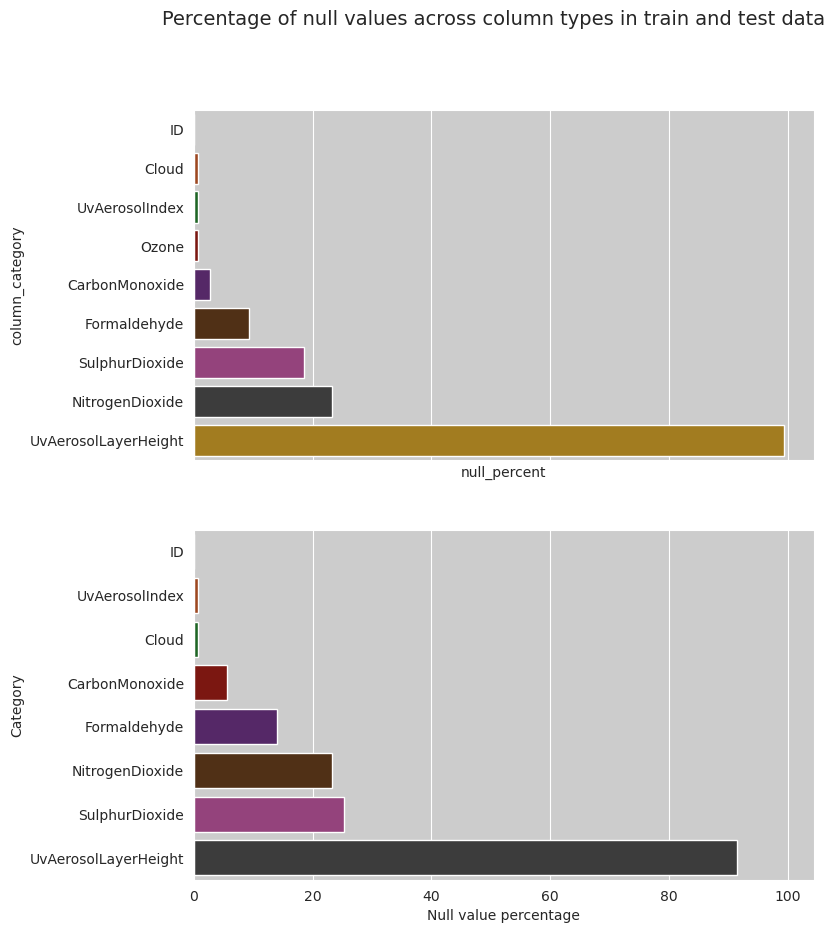

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

sns.barplot(x='null_percent', y='column_category', data=train_null, palette='dark', ax=ax1)
sns.barplot(x='null_percent', y='column_category', data=test_null, palette='dark', ax=ax2)

plt.xlabel("Null value percentage")
plt.ylabel("Category")
plt.suptitle("Percentage of null values across column types in train and test data", fontsize=14)
plt.show()

#### Observations:
- ##### UvAerosolLayerHeight category has close to 100 % null values.
- ##### NO2 and SO2 columns have close to 20% and Formaldehyde columns have nearly 10% null values
- ##### Rest columns don't have much null values

In [10]:
train.describe()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023.000000,79023.000000,79023.000000,79023.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,64414.000000,...,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,78539.000000,79023.000000
mean,-1.891072,29.880155,2020.000000,26.000000,0.000048,0.834848,0.000035,0.158418,-7.925870,37.436189,...,5592.377478,59420.297456,4670.430869,19.139241,0.271460,-10.784832,40.436976,-86.800583,27.925981,81.940552
std,0.694522,0.810375,0.816502,15.297155,0.000272,0.185382,0.000206,0.071364,64.263368,14.149950,...,1428.503002,9051.163609,1359.251583,13.547047,0.049434,30.374462,6.428216,37.837269,4.403835,144.299648
min,-3.299000,28.228000,2019.000000,0.000000,-0.000996,0.241822,-0.000887,0.000000,-179.537059,0.099237,...,1050.661782,24779.033704,1050.496816,1.844529,0.017697,-102.739731,2.998873,-153.464211,10.818288,0.000000
25%,-2.451000,29.262000,2019.000000,13.000000,-0.000096,0.705817,-0.000078,0.110535,-56.782383,28.844520,...,4595.400519,53175.779928,3680.856344,9.974574,0.241453,-30.309170,35.829907,-125.991158,24.686763,9.797995
50%,-1.882000,29.883000,2020.000000,26.000000,0.000024,0.809118,0.000019,0.161855,-12.441726,37.784299,...,5573.854309,59332.532548,4621.755170,15.130688,0.272747,-12.673914,41.119630,-84.644352,28.333630,45.593445
75%,-1.303000,30.471000,2021.000000,39.000000,0.000153,0.942792,0.000121,0.211824,72.059990,47.634875,...,6542.303642,65663.842684,5572.983223,23.785030,0.302892,9.402202,44.446272,-48.132701,31.499883,109.549595
max,-0.510000,31.532000,2021.000000,52.000000,0.004191,1.885239,0.004236,0.299998,122.095200,66.242012,...,12384.239458,89291.615576,11384.239458,250.000000,0.736514,78.223037,65.951248,-22.653170,42.060436,3167.768000


In [11]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

## Data visualization

### Geographical map

In [12]:
# This code has been taken from the competition starter notebook 
# https://www.kaggle.com/code/inversion/getting-started-eda

# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)

# Create point geometries
geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-0.510,29.290,train,POINT (29.29000 -0.51000)
1,-0.528,29.472,train,POINT (29.47200 -0.52800)
2,-0.547,29.653,train,POINT (29.65300 -0.54700)
3,-0.569,30.031,train,POINT (30.03100 -0.56900)
4,-0.598,29.102,train,POINT (29.10200 -0.59800)


In [13]:
# This code has been taken from the competition starter notebook 
# https://www.kaggle.com/code/inversion/getting-started-eda

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup= 
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

### Heatmap

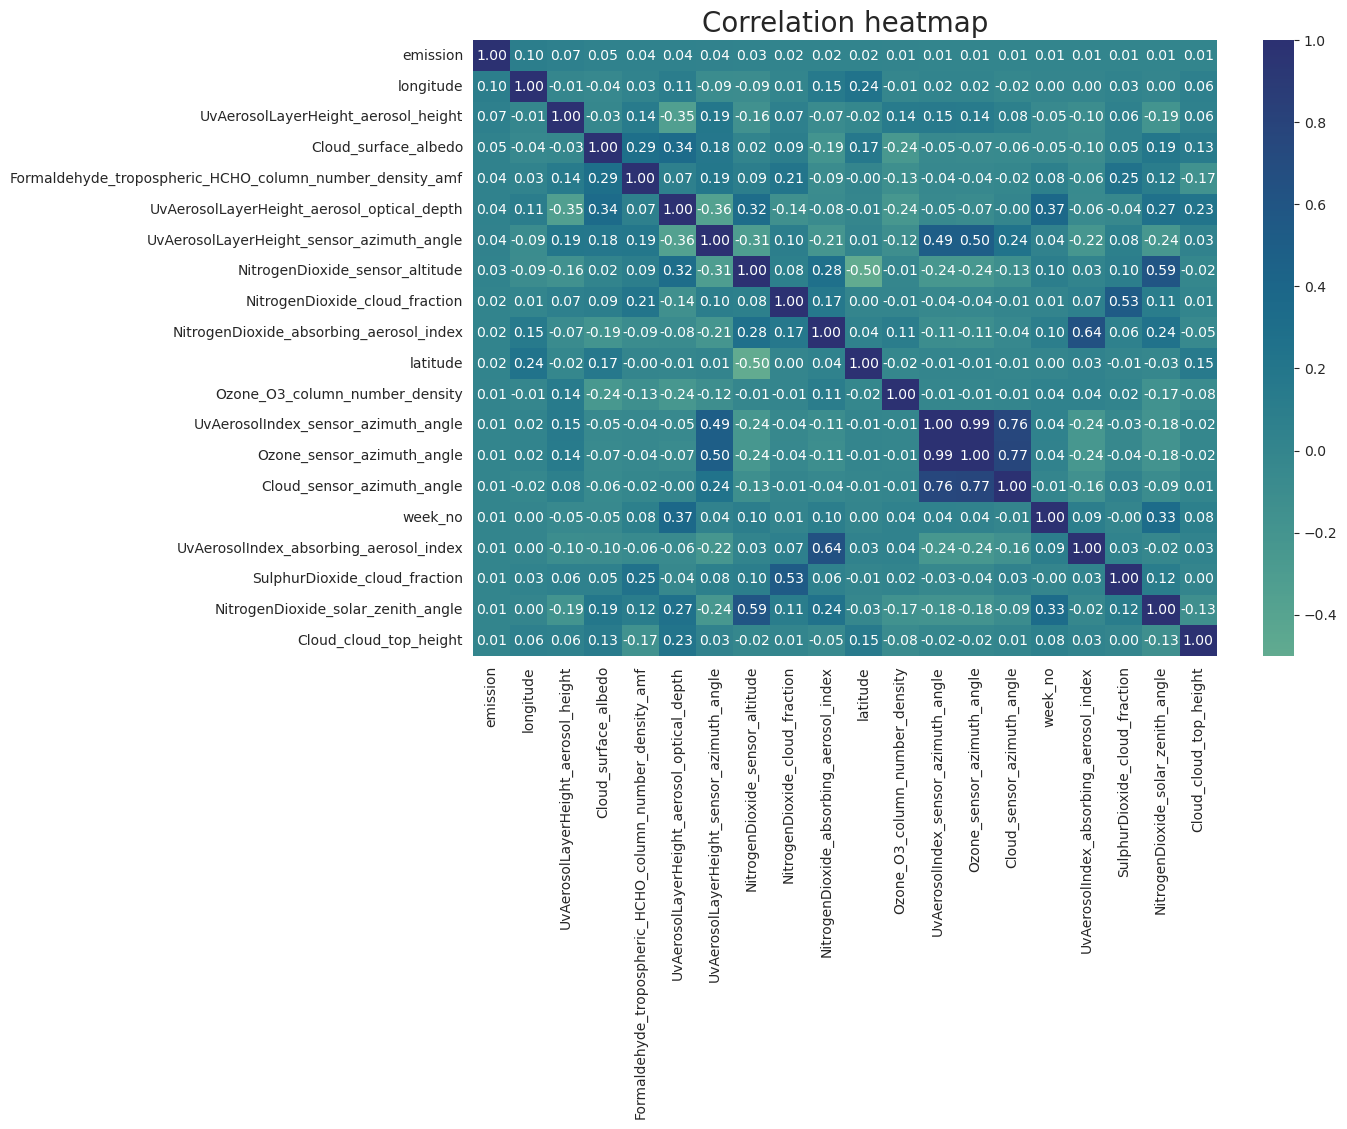

In [14]:
# Correlation of features with emission
corr_df = pd.DataFrame(train.corr()['emission'].sort_values(ascending=False))
corr = train[corr_df.index[:20]].corr()
plt.figure(figsize = (12, 8))
sns.heatmap(corr, cmap='crest', annot = True, fmt='.2f', center = 0)
plt.title('Correlation heatmap', fontsize = 20)
plt.show()

### Histogram

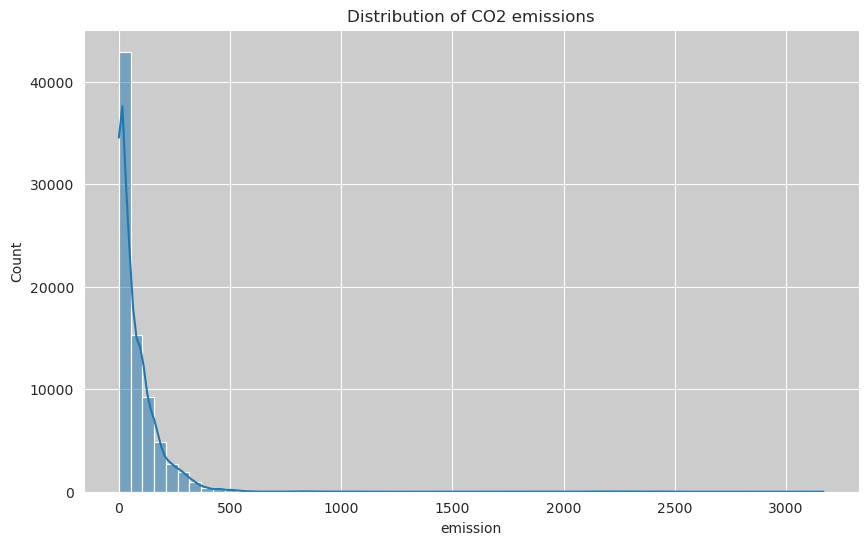

In [15]:
# Visualizing emissions
plt.figure(figsize=(10,6))
sns.histplot(x='emission', data=train, bins=60, kde=True)
plt.title("Distribution of CO2 emissions")
plt.show()

#### Observation:
##### The distribution of CO2 emissions looks to be a right-skewed distribution

### Stripplot

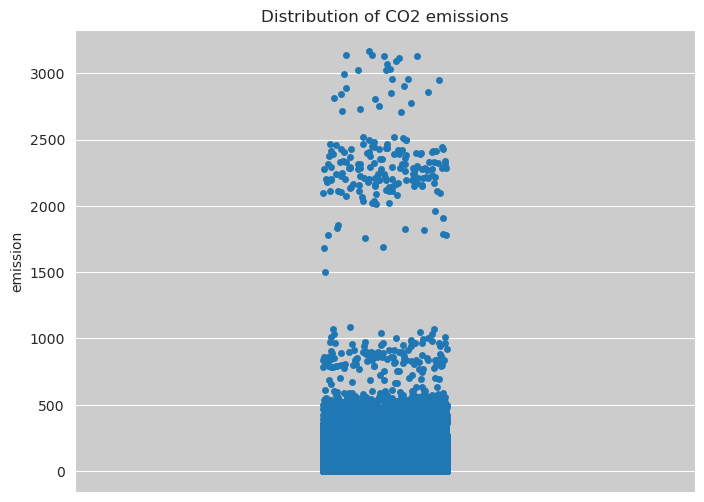

In [16]:
plt.figure(figsize=(8,6))
sns.stripplot(y='emission', data=train)
plt.title("Distribution of CO2 emissions")
plt.show()

#### Observation: 
##### CO2 emissions column has a large number of outliers

In [17]:
train.groupby(['latitude', 'longitude']).emission.count().reset_index()

,latitude,longitude,emission
0,-3.299,30.301,159
1,-3.287,29.713,159
2,-3.174,29.926,159
3,-3.161,28.839,159
4,-3.153,30.347,159
...,...,...,...
492,-0.598,29.102,159
493,-0.569,30.031,159
494,-0.547,29.653,159
495,-0.528,29.472,159


#### Observation:
##### There are 497 unique locations with each location containing 159 datapoints

### Average CO2 emissions

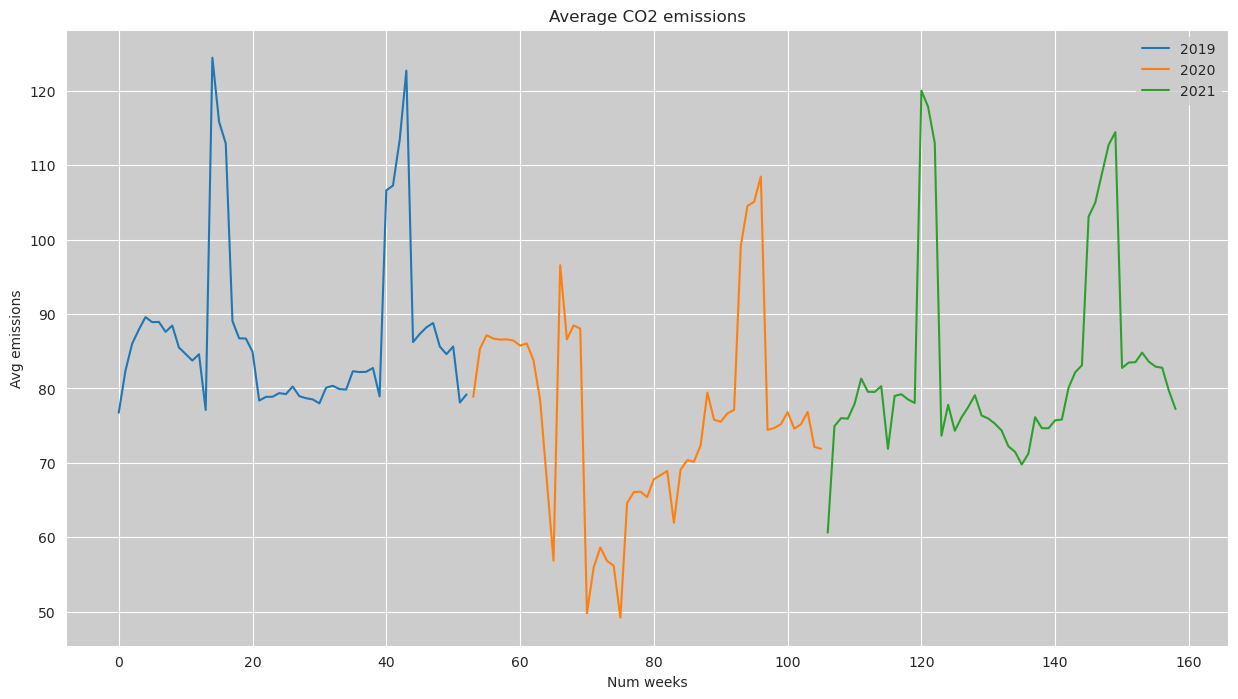

In [18]:
# Plot average CO2 emissions across the whole training data
plt.figure(figsize=(15,8))

train.groupby(['year', 'week_no']).emission.mean().reset_index().groupby('year').emission.plot()

plt.title("Average CO2 emissions")
plt.xlabel("Num weeks")
plt.ylabel("Avg emissions")

plt.legend()
plt.show()

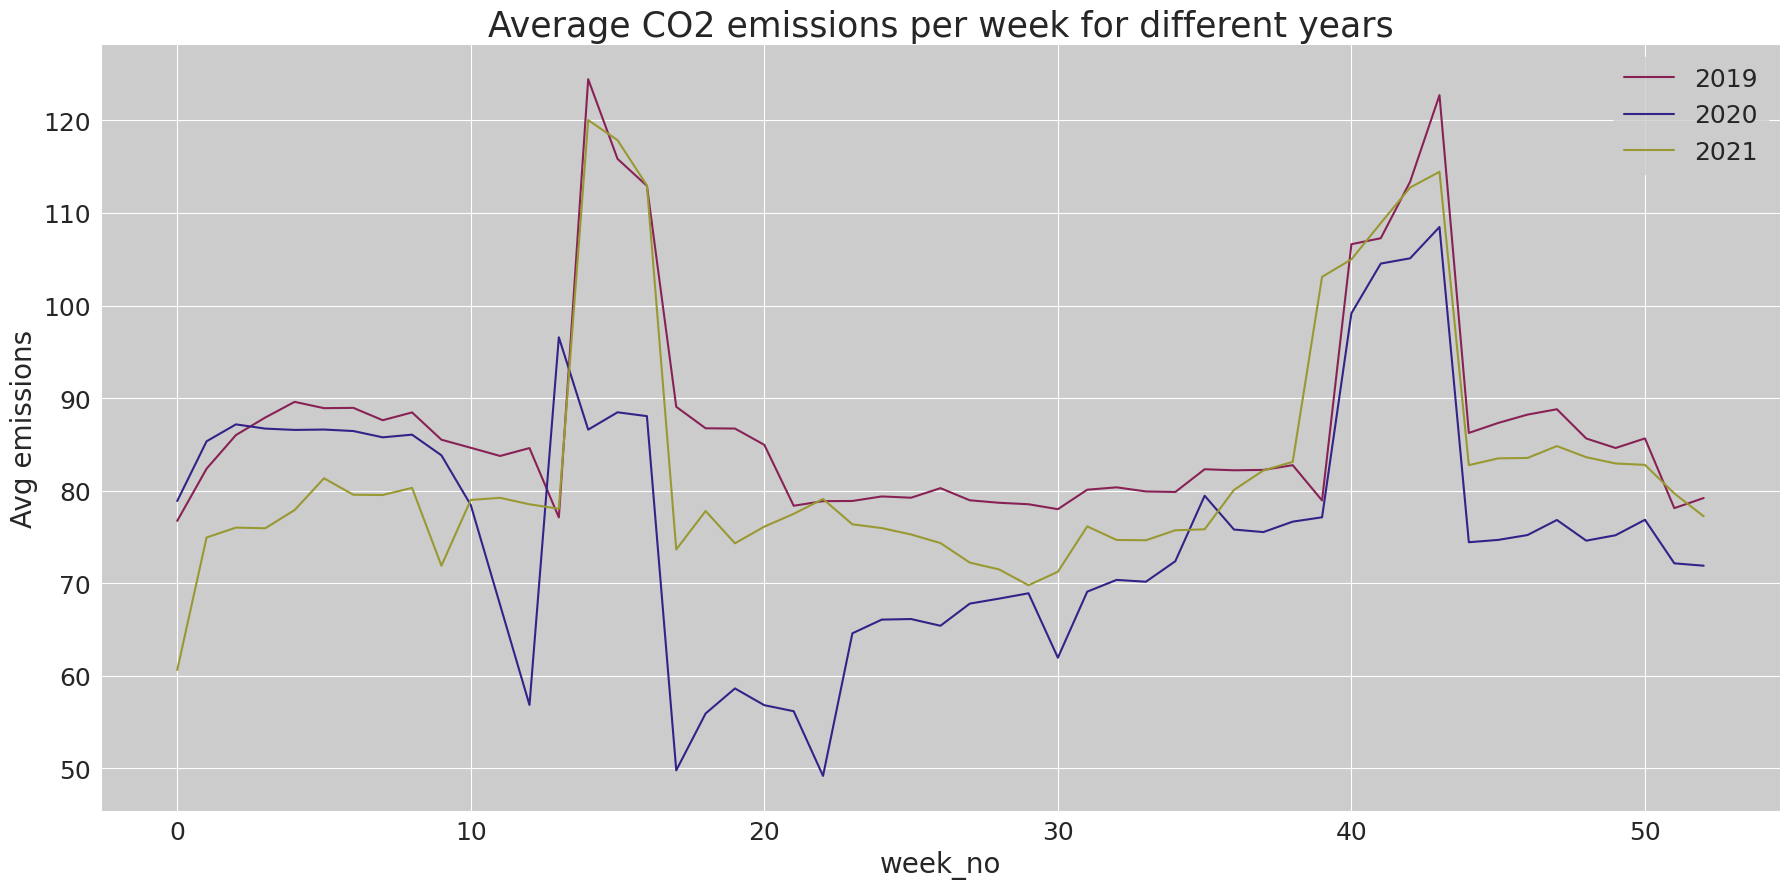

In [19]:
plt.figure(figsize=(18,9))
colors = ['#882255','#332288', '#999933']

for i, year in enumerate(train.year.unique()):
    train[train['year'] == year].groupby(['week_no'])['emission'].mean().plot(color=colors[i])
    
plt.xlabel("week_no", fontsize=20)
plt.ylabel("Avg emissions", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Average CO2 emissions per week for different years", fontsize=25)

plt.legend(train.year.unique(), fontsize=18)
plt.tight_layout()
plt.show()

#### Observation:
- ##### 2020 has the lowest mean emissions overall due to COVID.
- ##### 2019 and 2021 have somewhat same trend for emissions.

In [20]:
# train.groupby(['latitude', 'longitude']).emission.mean().plot()

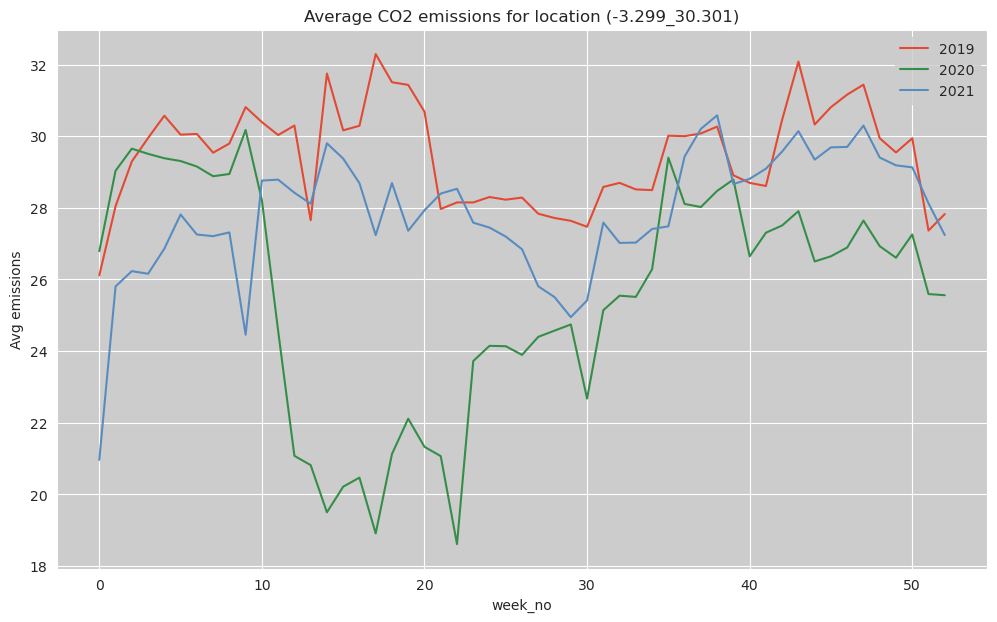

In [21]:
# Create location column by combining latitude and longitude
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

plt.figure(figsize=(12,7))
colors = ['#e34933', '#358e48', '#588cc0']
# CO2 emissions for a specific location
for i, year in enumerate(train.year.unique()):
    train[train['location'] == '-3.299_30.301'].groupby(['year', 'week_no']).emission.mean().loc[year].plot(color=colors[i])
    
plt.ylabel("Avg emissions")
plt.title("Average CO2 emissions for location (-3.299_30.301)")
plt.legend(train.year.unique())
plt.show()

##### The same trend can be seen for this particular location too